# Distance travelled by substitutions

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False

Imports and database setup.

In [2]:
from itertools import product

import pandas as pd
import seaborn as sb
import numpy as np
import networkx as nx
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic as wn_ic
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, memoized
from brainscopypaste.load import FAFeatureLoader
engine = init_db()

Build our data.

In [3]:
model = Model(Time.discrete, Source.majority, Past.last_bin, Durl.all, 1)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        source_token, destination_token = substitution.tokens
        source_lemma, destination_lemma = substitution.lemmas
        source_pos, destination_pos = substitution.tags
        data.append({'cluster_id': substitution.source.cluster.sid,
                     'destination_id': substitution.destination.sid,
                     'occurrence': substitution.occurrence,
                     'source_id': substitution.source.sid,
                     'source_token': source_token,
                     'destination_token': destination_token,
                     'source_pos': source_pos,
                     'destination_pos': destination_pos,
                     'source_lemma': source_lemma,
                     'destination_lemma': destination_lemma})

original_subs = pd.DataFrame(data)
del data

Got 6318 substitutions for model Model(time=Time.discrete, source=Source.majority, past=Past.last_bin, durl=Durl.all, max_distance=1)


100% (6318 of 6318) |######################| Elapsed Time: 0:00:38 Time: 0:00:38


Assign proper weight to each substitution.

In [4]:
distances = original_subs.copy()
divide_weight_sum = lambda x: x / distances.loc[x.index].weight.sum()

# Weight is 1, at first.
distances['weight'] = 1
# Divided by the number of substitutions that share a durl.
distances['weight'] = distances\
    .groupby(['destination_id', 'occurrence'])['weight']\
    .transform(divide_weight_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_weight_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
distances['weight'] = distances\
    .groupby('cluster_id')['weight']\
    .transform(divide_weight_sum)

## 2 Distances on the FA network

Get the FA norms undirected graph and invert its weights to use them as costs.

In [5]:
fa_loader = FAFeatureLoader()
avg_weight = np.mean([weight for _, _, weight in fa_loader._undirected_norms_graph.edges_iter(data='weight')])
fa_graph = nx.Graph()
fa_graph.add_weighted_edges_from(
    [(w1, w2, avg_weight / weight) for w1, w2, weight
     in fa_loader._undirected_norms_graph.edges_iter(data='weight')]
)

Compute distances on the FA network, using lemmas if tokens are not found.

In [6]:
fa_distances = distances.copy()
fa_distances['weighted_distance'] = np.nan
fa_distances['distance'] = np.nan

@memoized
def fa_shortest_path(source, destination, weighted):
    return nx.shortest_path_length(fa_graph, source, destination, 'weight' if weighted else None)

for i in ProgressBar(term_width=80)(fa_distances.index):
    # Use source token, or lemma if not found, or skip this substitution if not found
    if fa_graph.has_node(fa_distances.loc[i].source_token):
        source_word = fa_distances.loc[i].source_token
    elif fa_graph.has_node(fa_distances.loc[i].source_lemma):
        source_word = fa_distances.loc[i].source_lemma
    else:
        continue

    # Use destination token, or lemma if not found, or skip this substitution if not found
    if fa_graph.has_node(fa_distances.loc[i].destination_token):
        destination_word = fa_distances.loc[i].destination_token
    elif fa_graph.has_node(fa_distances.loc[i].destination_lemma):
        destination_word = fa_distances.loc[i].destination_lemma
    else:
        continue
    
    fa_distances.loc[i, 'weighted_distance'] = fa_shortest_path(source_word, destination_word, weighted=True)
    fa_distances.loc[i, 'distance'] = fa_shortest_path(source_word, destination_word, weighted=False)

100% (6318 of 6318) |######################| Elapsed Time: 0:02:00 Time: 0:02:00


Plot them.

In [7]:
def plot_distances(data, name, bin_count):
    distances = data[name]
    if bin_count <= 0:
        bin_count = int(distances.max() - distances.min() + 1)
        bins = np.arange(distances.min(), distances.max() + 2) - .5
        d_bins = pd.cut(distances, bins, right=False, labels=False)
    else:
        d_bins, bins = pd.cut(distances, bin_count, right=False, labels=False, retbins=True)

    middles = (bins[:-1] + bins[1:]) / 2
    width = middles[1] - middles[0]

    # Compute bin values.
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[d_bins == i].weight.sum()

    # Plot.
    plt.bar(middles - width / 2, heights, width=width)

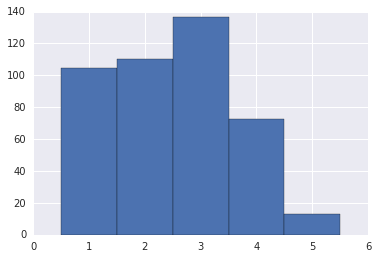

In [8]:
plot_distances(fa_distances, 'distance', -1)

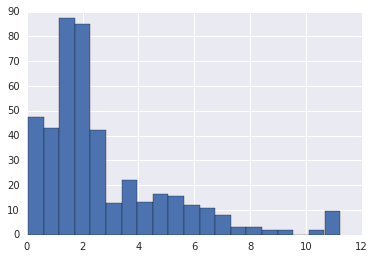

In [9]:
plot_distances(fa_distances, 'weighted_distance', 20)

In [26]:
print('{} substitutions are not taken into account in the graphs above'
      ' (because they involve words unknown to FA).'
      .format(len(fa_distances[np.isnan(fa_distances.distance)])))

1775 substitutions are not taken into account in the graphs above (because they involve words unknown to FA).


## 3 Distances with WordNet similarities

In [10]:
infocontent = wn_ic.ic('ic-brown.dat')
wordnet_poses = {'a', 'n', 'r', 's', 'v'}

def build_wordnet_distances(data, name, ic_based, pos_based=False, distance_kws={}):
    pos_based = ic_based or pos_based
    wn_distances = data.copy()
    wn_distances['distance'] = np.nan

    skipped_no_synsets = 0
    skipped_unknown_pos = 0
    skipped_incongruent_pos = 0
    skipped_noic_pos = 0
    for i in ProgressBar(term_width=80)(data.index):
        if pos_based:
            pos = data.loc[i].source_pos[0].lower()
            if pos not in wordnet_poses:
                skipped_unknown_pos += 1
                continue
            if data.loc[i].destination_pos[0].lower() != pos:
                skipped_incongruent_pos += 1
                continue
            if ic_based and (pos not in infocontent.keys()):
                skipped_noic_pos += 1
                continue
        else:
            pos = None
        
        # Use source token, or lemma if not found
        source_synsets = wn.synsets(wn_distances.loc[i].source_token, pos=pos)
        if len(source_synsets) == 0:
            source_synsets = wn.synsets(wn_distances.loc[i].source_lemma, pos=pos)

        # Use destination token, or lemma if not found
        destination_synsets = wn.synsets(wn_distances.loc[i].destination_token, pos=pos)
        if len(destination_synsets) == 0:
            destination_synsets = wn.synsets(wn_distances.loc[i].destination_lemma, pos=pos)
        
        # Skip this substitution if no corresponding synsets were found
        if len(source_synsets) == 0 or len(destination_synsets) == 0:
            skipped_no_synsets += 1
            continue
        
        def get_distance(s1, s2):
            distance_func = getattr(s1, name)
            if ic_based:
                return distance_func(s2, infocontent, **distance_kws)
            else:
                return distance_func(s2, **distance_kws)
        
        distances = [get_distance(s1, s2)
                     for s1, s2 in product(source_synsets, destination_synsets)
                     if get_distance(s1, s2) is not None]
        wn_distances.loc[i, 'distance'] = np.mean(distances)
    
    if pos_based:
        print('Skipped {} substitutions because their source was unknown to WordNet'
              .format(skipped_unknown_pos))
        print('Skipped {} substitutions because their source and destination pos were different'
              .format(skipped_incongruent_pos))
        if ic_based:
            print('Skipped {} substitutions because their source pos was not in {}'
                  .format(skipped_noic_pos, infocontent.keys()))
    print('Skipped {} substitutions because no synsets were found'.format(skipped_no_synsets))

    return wn_distances

WordNet defines all sorts of distances/similarities between synsets. We're trying all of them to see what it looks like.

### 3.1 Jiang-Conrath similarity

In [11]:
jcn_similarities = build_wordnet_distances(distances, 'jcn_similarity', True)

 98% (6240 of 6318) |##################### | Elapsed Time: 0:00:11 ETA:  0:00:00

Skipped 995 substitutions because their source was unknown to WordNet
Skipped 1053 substitutions because their source and destination pos were different
Skipped 117 substitutions because their source pos was not in dict_keys(['v', 'n'])
Skipped 0 substitutions because no synsets were found


100% (6318 of 6318) |######################| Elapsed Time: 0:00:12 Time: 0:00:12


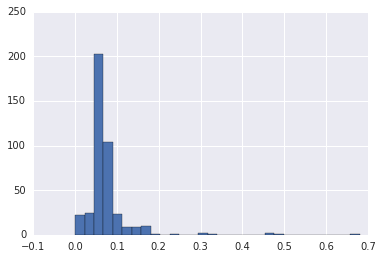

In [12]:
plot_distances(jcn_similarities.loc[jcn_similarities.distance <= 1], 'distance', 30)

### 3.2 Lin similarity

In [13]:
lin_similarities = build_wordnet_distances(distances, 'lin_similarity', True)

 97% (6161 of 6318) |##################### | Elapsed Time: 0:00:08 ETA:  0:00:00

Skipped 995 substitutions because their source was unknown to WordNet
Skipped 1053 substitutions because their source and destination pos were different
Skipped 117 substitutions because their source pos was not in dict_keys(['v', 'n'])
Skipped 0 substitutions because no synsets were found


100% (6318 of 6318) |######################| Elapsed Time: 0:00:08 Time: 0:00:08


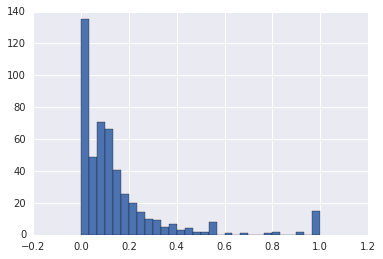

In [14]:
plot_distances(lin_similarities, 'distance', 30)

### 3.3 Resnik similarity

In [15]:
res_similarities = build_wordnet_distances(distances, 'res_similarity', True)

 98% (6240 of 6318) |##################### | Elapsed Time: 0:00:08 ETA:  0:00:00

Skipped 995 substitutions because their source was unknown to WordNet
Skipped 1053 substitutions because their source and destination pos were different
Skipped 117 substitutions because their source pos was not in dict_keys(['v', 'n'])
Skipped 0 substitutions because no synsets were found


100% (6318 of 6318) |######################| Elapsed Time: 0:00:08 Time: 0:00:08


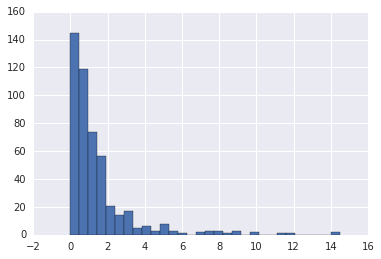

In [16]:
plot_distances(res_similarities.loc[res_similarities.distance <= 100], 'distance', 30)

### 3.4 Leacock Chodorow similarity

In [17]:
lch_similarities = build_wordnet_distances(distances, 'lch_similarity', False, pos_based=True)

  1% (  79 of 6318) |                      | Elapsed Time: 0:00:11 ETA:  0:02:10/home/sl/.virtualenvs/brainscopypaste/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
 98% (6240 of 6318) |##################### | Elapsed Time: 0:00:52 ETA:  0:00:00

Skipped 995 substitutions because their source was unknown to WordNet
Skipped 1053 substitutions because their source and destination pos were different
Skipped 0 substitutions because no synsets were found


100% (6318 of 6318) |######################| Elapsed Time: 0:00:52 Time: 0:00:52


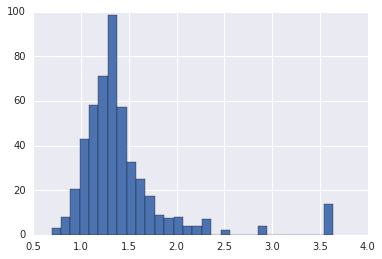

In [18]:
plot_distances(lch_similarities, 'distance', 30)

### 3.5 Path Distance similarity (with hypernym/hyponym relationships)

In [19]:
path_similarities = build_wordnet_distances(distances, 'path_similarity', False)

/home/sl/.virtualenvs/brainscopypaste/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
 98% (6240 of 6318) |##################### | Elapsed Time: 0:01:07 ETA:  0:00:24

Skipped 0 substitutions because no synsets were found


100% (6318 of 6318) |######################| Elapsed Time: 0:01:08 Time: 0:01:08


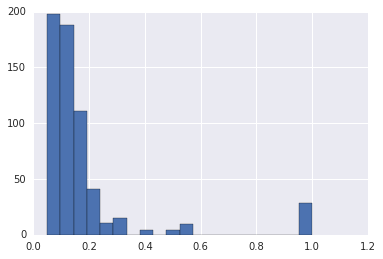

In [20]:
plot_distances(path_similarities, 'distance', 20)

### 3.6 Shortest Path distance (less is more similar, more is less similar)

In [21]:
shortest_path_distances = build_wordnet_distances(distances, 'shortest_path_distance', False, pos_based=True,
                                                  distance_kws={'simulate_root': True})

 98% (6240 of 6318) |##################### | Elapsed Time: 0:00:28 ETA:  0:00:00

Skipped 995 substitutions because their source was unknown to WordNet
Skipped 1053 substitutions because their source and destination pos were different
Skipped 0 substitutions because no synsets were found


100% (6318 of 6318) |######################| Elapsed Time: 0:00:28 Time: 0:00:28


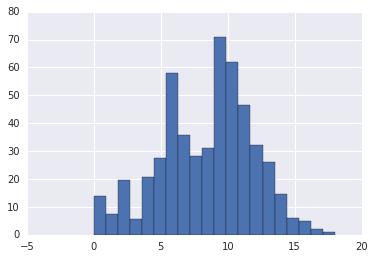

In [22]:
plot_distances(shortest_path_distances, 'distance', 20)

### 3.7 Wu-Palmer similarity

In [23]:
wup_similarities = build_wordnet_distances(distances, 'wup_similarity', False)

/home/sl/.virtualenvs/brainscopypaste/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
 98% (6240 of 6318) |##################### | Elapsed Time: 0:01:07 ETA:  0:00:00

Skipped 0 substitutions because no synsets were found


100% (6318 of 6318) |######################| Elapsed Time: 0:01:07 Time: 0:01:07


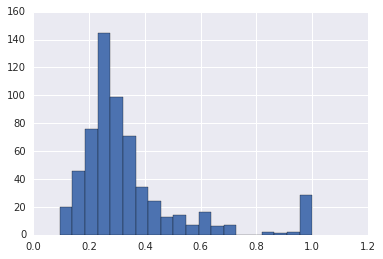

In [24]:
plot_distances(wup_similarities, 'distance', 20)

## 4 Comments

While the FA distance scores are somewhat interpretable, they still don't say much.

The WordNet distances and similarities make no sense to whatsoever. It might mean something when compared to some $\mathcal{H}_0$ where destination word is chosen randomly, but just like this the similarity and distance scores are meaningless. Two more problems: most of them only accept words that have exact same POS (which filters out about 1000 substitutions out of ~6000), and because the meanings of a word are so many (

One point is that most substitutions are in the low similarities rather than the high ones.